In [1]:
# !pip install tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from datetime import datetime 
%matplotlib inline
start_time = datetime.now() 

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
image_dir = '../input/flowers-recognition/flowers'
labels = ['daisy','dandelion','rose','sunflower','tulip']
nb = len(labels)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D,MaxPool2D,\
Input,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



In [4]:
#ref -> https://github.com/mrc03/Flower-Recognition-Kaggle-CNN-Keras/blob/master/Flower_Recognition_VGG16(trans.%20learn).ipynb

shape = 150
input_shape = (shape,shape)
def get_XandY(train_dir,labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir,label)
        for image in tqdm(os.listdir(folder)):
            img=load_img(os.path.join(folder,image), target_size=input_shape)
            img=img_to_array(img)
            img=img/255.0
            dataset.append((img,count))
        print(">>> ",label)
        count+=1
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    
    return np.array(X),np.array(y)

In [5]:
images,label = get_XandY(image_dir,labels)

100%|██████████| 764/764 [00:04<00:00, 182.44it/s]


>>>  daisy


100%|██████████| 1052/1052 [00:06<00:00, 170.41it/s]


>>>  dandelion


100%|██████████| 784/784 [00:04<00:00, 179.60it/s]


>>>  rose


100%|██████████| 733/733 [00:04<00:00, 153.60it/s]


>>>  sunflower


100%|██████████| 984/984 [00:06<00:00, 163.41it/s]


>>>  tulip


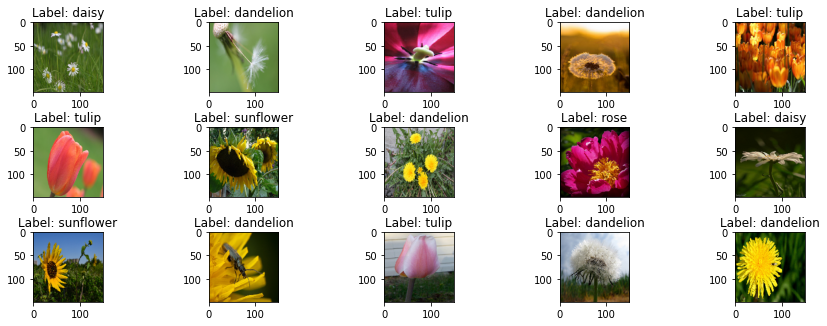

In [6]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[label[i]]}')

In [7]:

np.unique(label,return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 764, 1052,  784,  733,  984]))

In [8]:
label = to_categorical(label,5)

In [9]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(images,label,stratify=label,random_state=42,test_size=0.25)

print(f"Train length:{len(xtrain)} \n Test length: {len(xtest)}")

Train length:3237 
 Test length: 1080


In [10]:
np.random.seed(42)
tf.random.set_seed(42)
np.random.seed()

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False
)  # randomly flip images


datagen.fit(xtrain)

In [12]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(shape,shape,3), pooling='avg')
 

2022-04-25 03:57:36.886312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 03:57:36.998234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 03:57:36.999073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 03:57:37.000360: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [14]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)
filepath= "best_model.h5"
ck = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

cb =[
    ck

]

In [15]:
%%time
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))


for layer in base_model.layers:
    layer.trainable=True

model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
print("No fo Layers: ",len(model.layers))
History = model.fit(datagen.flow(xtrain,ytrain, batch_size=batch_size),callbacks = cb,
                              epochs = 50, validation_data = (xtest,ytest),
                              verbose = 1, steps_per_epoch=xtrain.shape[0] // batch_size)


No fo Layers:  4


2022-04-25 03:57:41.468580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-25 03:57:43.895753: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 40s 1s/step - loss: 0.8586 - accuracy: 0.6777 - val_loss: 0.9232 - val_accuracy: 0.6935

Epoch 00001: val_accuracy improved from -inf to 0.69352, saving model to best_model.h5
Epoch 2/50
25/25 [==============================] - 20s 791ms/step - loss: 0.4359 - accuracy: 0.8437 - val_loss: 0.6788 - val_accuracy: 0.7907

Epoch 00002: val_accuracy improved from 0.69352 to 0.79074, saving model to best_model.h5
Epoch 3/50
25/25 [==============================] - 20s 792ms/step - loss: 0.3536 - accuracy: 0.8742 - val_loss: 0.7133 - val_accuracy: 0.7407

Epoch 00003: val_accuracy did not improve from 0.79074
Epoch 4/50
25/25 [==============================] - 20s 794ms/step - loss: 0.3043 - accuracy: 0.8874 - val_loss: 0.4707 - val_accuracy: 0.8685

Epoch 00004: val_accuracy improved from 0.79074 to 0.86852, saving model to best_model.h5
Epoch 5/50
25/25 [==============================] - 20s 801ms/step - loss: 0.2253 - accuracy: 0.9161 - val_loss: 0.4

In [16]:
# model.save("ACCU_90_shape_150.h5")

              precision    recall  f1-score   support

       daisy       0.89      0.92      0.91       191
   dandelion       0.99      0.90      0.94       263
        rose       0.91      0.85      0.88       196
   sunflower       0.88      0.96      0.92       184
       tulip       0.86      0.91      0.88       246

    accuracy                           0.91      1080
   macro avg       0.91      0.91      0.91      1080
weighted avg       0.91      0.91      0.91      1080



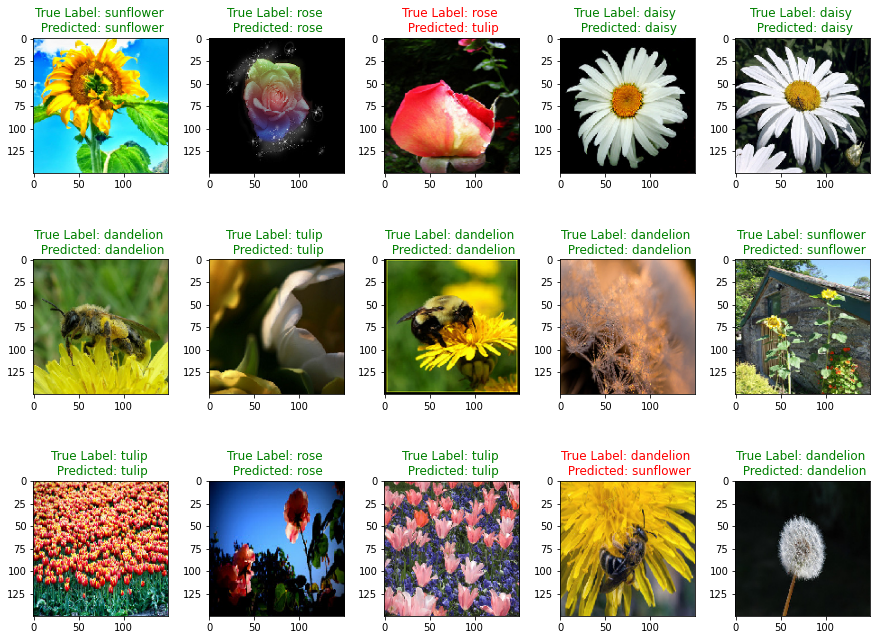

In [17]:
transfer_learning_best_model =  tf.keras.models.load_model('best_model.h5')

from sklearn.metrics import classification_report

print(classification_report(np.argmax(ytest,axis = 1),np.argmax(transfer_learning_best_model.predict(xtest),axis = 1),target_names = labels))


pred = transfer_learning_best_model.predict(xtest)
pred = np.argmax(pred,axis = 1)
ytest = np.argmax(ytest,axis = 1)
plt.figure(figsize = (15 , 19))
n = 0
for i in range(15):
    if pred[i]==ytest[i]:
        
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.title(f'True Label: {labels[ytest[i]]} \n Predicted: {labels[pred[i]]}',color = 'green')

        plt.imshow(xtest[i])
#         plt.xlabel(f"",color="green")
    else:
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.title(f'True Label: {labels[ytest[i]]} \n Predicted: {labels[pred[i]]}',color = 'red')

        plt.imshow(xtest[i])

In [18]:
np.save("xtrain.npy",xtrain)
np.save("xtest.npy",xtest)
np.save("ytrain.npy",ytrain)
np.save("ytest.npy",ytest)

In [19]:
np.load("xtrain.npy").shape

(3237, 150, 150, 3)

In [20]:
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:19:07.732549
